<a href="https://colab.research.google.com/github/edponce/DoyleInvestigators/blob/master/Project1_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import re
import collections
import urllib.request
import urllib.parse
import numpy as np
import seaborn as sns  # 0.10.1 (0.11 fails in histogram plot)
import pandas
import matplotlib.pyplot as plt

###$\color{brown}{\rm Corpus~Selection}$

In [ ]:
CORPUS_URL = {
    'The Valley of Fear': "http://www.gutenberg.org/files/3289/3289.txt",
    'A Study of Scarlet': "http://www.gutenberg.org/files/244/244.txt",
    'The Sign of the Four': "http://www.gutenberg.org/files/2097/2097.txt",
    'The Hound of the Baskervilles': "http://www.gutenberg.org/files/2852/2852.txt",
    'The Boscombe Valley Mystery': 'https://www.gutenberg.org/files/1661/1661.txt',
}

###$\color{brown}{\rm Read~Web~Page~Content}$
Read the corpus from web page or file to start processing.

In [ ]:
def get_corpus_from_url(url):
    with urllib.request.urlopen(url) as fd:
        text = fd.read()
        try:
            return text.decode('utf-8')
        except UnicodeDecodeError:
            return text.decode('iso-8859-1')


def get_corpus_from_file(file):
    with open(file) as fd:
        return fd.read()


def get_corpus(key):
    def validate_url(url):
        parsed_url = urllib.parse.urlparse(url)
        return all([parsed_url.scheme, parsed_url.netloc, parsed_url.path])

    # Check if a filename was provided
    if os.path.isfile(key):
        return get_corpus_from_file(key)
    else:
        if key in CORPUS_URL:
            file = os.path.basename(CORPUS_URL[key])
            if os.path.isfile(file):
                return get_corpus_from_file(file)

    # Check if a URL was provided
    if validate_url(key):
        return get_corpus_from_url(key)
    else:
        if key in CORPUS_URL:
            url = CORPUS_URL[key]
            if validate_url(url):
                return get_corpus_from_url(url)

    raise Exception(f"corpus '{key}' not found")

###$\color{brown}{\rm Regex~for~Headings}$
Functions to get spans of headings (Gutenberg tags, parts, chapters, adventures, etc.)

In [ ]:
def get_newline_index(text):
    """Find the index of the first newline in the text.
    This is used to skip/correct one newline at beginning of headings.
    """
    match = re.match(r'[ \t\r]*\n', text)
    return match.end() if match else 0


def get_gutenberg_start_heading(text, span=None):
    """Find Gutenberg's start tag (and producer, if available).

    Notes:
        * re.match() searches at the beginning of strings, but there are
          certain character combinations that are not considered strings,
          and thus need to use re.search(), even if it is at the beginning
          of line. An example are the asterisks in the Gutenberg START
          tag.
    """
    if not span:
        span = (0, len(text))

    match = re.search(
        r'(\s*\n){2,}'  # pre-whitespace, no indentation
        r'\*{3}\s*'  # 3 asterisks
        r'start[^\r\n]+'  # tag text
        r'\s*\*{3}'  # 3 asterisks
        r'(\s*\nproduced by.+)?'  # producer line
        r'(\s*\n){2,}',  # post-whitespace
        text[span[0]:span[1]],
    )

    if match:
        span = match.span()
        offs = get_newline_index(text[span[0]:span[1]])
        return span[0] + offs, span[1]


def get_gutenberg_end_heading(text, span=None):
    """Find Gutenberg's end tag (and transcriber's notes, if available).

    Notes:
        * Duplicate/similar Gutenberg end tags.
        * Use a newline before transcriber note to prevent matching similar
          (but indented) notes at beginning of text.
        * Use DOTALL flag to match transcriber's notes across multiple lines.
          But be wary that using DOTALL prevents the use of '.+' for other
          cases, so use '[^\r\n]' instead.
    """
    if not span:
        span = (0, len(text))

    match = re.search(
        r'('
        r'(\s*\n){2,}'  # pre-whitespace, no indentation
        r'(original transcriber.+\s*\n)?'  # transcriber notes
        r'end[^\r\n]+'  # duplicate/similar tag text
        r')?'
        r'\s*\n'  # pre-whitespace, no indentation
        r'\*{3}\s*'  # 3 asterisks
        r"end[^\r\n]+"  # tag text
        r'\s*\*{3}'  # 3 asterisks
        r'(\s*\n){2,}',  # post-whitespace
        text[span[0]:span[1]],
        flags=re.DOTALL,
    )

    if match:
        span = match.span()
        offs = get_newline_index(text[span[0]:span[1]])
        return span[0] + offs, span[1]


def get_named_headings(text, name, span=None):
    """Find named headings with title."""
    if not span:
        span = (0, len(text))

    spans = [
        (match.start() + span[0], match.end() + span[0])
        for match in re.finditer(
            r'(\s*\n){2,}'  # pre-whitespace, no indentation
            r'('
            fr'{name}[ \t]+(\d+|[ivxlcd]+)'  # label with Arabic or Roman numbering
            r'(-+|\.)?'  # label-title delimiter
            r'((\s*\n){2})?'  # whitespace for titles two line apart
            r'.*(\r?\n.*)?'  # title (muti-line support)
            r'|'  # cases: name # \s* label, # name/label
            r'(\d+|[ivxlcd]+)'  # label with Arabic or Roman numbering
            r'(-+|\.)?'  # label-title delimiter
            fr'[ \t]+.*{name}.*'  # label with name
            r')'
            r'(\s*\n){2,}',  # post-whitespace
            text[span[0]:span[1]],
        )
    ]

    if spans:
        _spans = []
        for _span in spans:
            offs = get_newline_index(text[_span[0]:_span[1]])
            _spans.append((_span[0] + offs, _span[1]))
        return _spans


def get_numbered_headings(text, span=None):
    """Find numbered headings with no title."""
    if not span:
        span = (0, len(text))

    spans = [
        (match.start() + span[0], match.end() + span[0])
        for match in re.finditer(
            r'(\s*\n){2,}'  # pre-whitespace, no indentation
            fr'(\d+|[ivxlcd]+)'  # label with Arabic or Roman numbering
            r'(-+|\.)'  # label-title delimiter
            r'(\s*\n){2,}',  # post-whitespace
            text[span[0]:span[1]]
        )
    ]

    if spans:
        _spans = []
        for _span in spans:
            offs = get_newline_index(text[_span[0]:_span[1]])
            _spans.append((_span[0] + offs, _span[1]))
        return _spans


def get_epilogue_heading(text, span=None):
    if not span:
        span = (0, len(text))

    match = re.search(
        r'(\s*\n){2,}'  # pre-whitespace, no indentation
        r'epilogue'  # tag text
        r'(\s*\n){2,}',  # post-whitespace
        text[span[0]:span[1]]
    )

    if match:
        span = match.span()
        offs = get_newline_index(text[span[0]:span[1]])
        return span[0] + offs, span[1]

Functions to get spans of ROI and corresponding text.

In [ ]:
def get_headings_map(
    text,
    headings=['part', 'chapter', 'adventure', 'epilogue', 'numbered'],
):
    """Create a list of all heading spans, guarantees at least one set
    of bounding spans.

    Args:
        headings (str, List[str]): Heading names to search for.
    """
    if not isinstance(headings, list):
        headings = [headings]

    headings_map = {}
    _headings_map = {}

    # Always available heading, all text
    text_heading = '_text_'

    # Ensure there is always a begin "span"
    start_span = get_gutenberg_start_heading(text)
    if not start_span:
        start_span = 0, 0

    # Ensure there is always an end "span"
    end_span = get_gutenberg_end_heading(text)
    if not end_span:
        end_span = len(text), len(text)
    headings_map[text_heading] = [start_span, end_span]
    if text_heading in headings:
        headings.remove(text_heading)

    # Optional
    span = get_epilogue_heading(text)
    if span:
        heading = 'epilogue'
        _headings_map[heading] = [span, headings_map[text_heading][1]]
        if heading in headings:
            headings_map[heading] = _headings_map[heading]
            headings.remove(heading)

    # Optional
    spans = get_numbered_headings(text)
    if spans:
        heading = 'numbered'
        _headings_map[heading] = spans
        if heading in headings:
            headings_map[heading] = _headings_map[heading]
            headings.remove(heading)

    # Optional
    if headings:
        for heading in headings:
            spans = get_named_headings(text, heading)
            if spans:
                headings_map[heading] = spans
                if 'epilogue' in _headings_map:
                    headings_map[heading].append(_headings_map['epilogue'][0])
                else:
                    headings_map[heading].append(headings_map[text_heading][1])
    return headings_map


def get_rois(text, name=None, num=None, *, headings_map=None):
    """Get span bounding a ROI.

    Args:
        name (str): ROI

        num (int, Iterable[int]): Number of ROI, [1,N]
    """
    if not headings_map:
        headings_map = get_headings_map(text)

    # Always available heading, all text
    text_heading = '_text_'

    rois = []
    if not name:
        rois = [(headings_map[text_heading][0][1], headings_map[text_heading][1][0])]
    elif name in headings_map:
        spans = headings_map[name]
        if num is None:
            rois = [
                (spans[i][1], spans[i + 1][0])
                for i in range(len(spans) - 1)
            ]
        else:
            rois = [
                (spans[i - 1][1], spans[i][0])
                for i in ([num] if isinstance(num, int) else num)
                if i >= 1 and i < (len(spans))
            ]

    if rois:
        # If necessary, skip last inner heading
        _rois = []
        for roi in rois:
            value = roi[1]
            for spans in headings_map.values():
                for span in spans:
                    if roi[1] > span[0] and roi[1] <= span[1]:
                        value = span[0]
            _rois.append((roi[0], value))
        return _rois


def get_text(text, span):
    if isinstance(span[0], int):
        span = [span]

    roi = ''
    for _span in span:
        roi += text[_span[0]:_span[1]]
    return roi

### To revisit

In [ ]:
def get_part(text, part_num, *, part_labels=None):
    """Get span of a selected part.

    Args:
        part_num (int): Natural number of parts [1-N]
    """
    # NOTE: This can be a required parameter, but simplifies invocation of this function.
    if part_labels is None:
        part_labels = get_gutenberg_part_labels(text)
    if part_num < 1 or part_num > len(part_labels):
        raise Exception('part number out-of-range')

    start = part_labels[part_num - 1].end()
    if part_num == len(part_labels):
        epilogue_label = get_gutenberg_epilogue_label(text)
        end = (
            epilogue_label.start()
            if epilogue_label
            else get_gutenberg_end_tag(text).start()
        )
    else:
        end = part_labels[part_num].start()
    return start, end


def get_parts(text):
    part_labels = get_gutenberg_part_labels(text)
    for part_num in range(1, len(part_labels) + 1):
        yield get_part(text, part_num, part_labels=part_labels)


def get_chapter(text, chapter_num, part_num=None, *, chapter_labels=None, part_labels=None):
    """Get span of chapter.

    Args:
        chapter_num (int): Natural number of chapters [1-N]

        part_num (int): Natural number of parts [1-N]
    """
    # NOTE: This can be a required value. This simplifies invocation of this function.
    if chapter_labels is None:
        chapter_labels = get_gutenberg_chapter_labels(text)
    if chapter_num < 1 or chapter_num > len(chapter_labels):
        raise Exception('chapter number out-of-range')

    if part_labels is None:
        part_labels = get_gutenberg_part_labels(text)
    if part_num is not None and (part_num < 1 or part_num > len(part_labels)):
        raise Exception('part number out-of-range')

    if part_num is not None:
        # Filter chapters not found in selected part
        part = get_part(text, part_num, part_labels=part_labels)
        chapter_labels = [
            label
            for label in chapter_labels
            if label.end() >= part[0] and label.end() <= part[1]
        ]

    # Last chapter
    start = chapter_labels[chapter_num - 1].end()
    if chapter_num == len(chapter_labels):
        # Last chapter of last part
        if part_num is None or part_num == len(part_labels):
            epilogue_label = get_gutenberg_epilogue_label(text)
            end = (
                epilogue_label.start()
                if epilogue_label
                else get_gutenberg_end_tag(text).start()
            )
        # Last chapter of intermediate part
        elif part_num is None:
            end = chapter_labels[chapter_num].start()
        else:
            end = part[1]
    else:
        end = chapter_labels[chapter_num].start()
    return start, end


def get_chapters(text, part_num=None):
    """Get iterator of chapter spans.

    Args:
        part_num (int): Natural number of parts [1-N]
    """
    chapter_labels = get_gutenberg_chapter_labels(text)
    part_labels = get_gutenberg_part_labels(text)

    # Text has parts
    if part_labels:
        if part_num is not None and (part_num < 1 or part_num > len(part_labels)):
            raise Exception('part number out-of-range')

        for part_num in (
            range(1, len(part_labels) + 1)
            if part_num is None
            else range(part_num, part_num + 1)
        ):
            # Filter chapters not found in current part
            part = get_part(text, part_num, part_labels=part_labels)
            _chapter_labels = [
                label
                for label in chapter_labels if label.end() >= part[0] and label.end() <= part[1]
            ]
            for chapter_num in range(1, len(_chapter_labels) + 1):
                yield get_chapter(text, chapter_num, part_num, chapter_labels=_chapter_labels, part_labels=part_labels)

    # Text does not has parts
    else:
        if part_num is not None:
            print('Warning: no parts found, so part-related parameters are ignored')
        for chapter_num in range(1, len(chapter_labels) + 1):
            yield get_chapter(text, chapter_num, chapter_labels=chapter_labels)

# Tokenization
Get paragraphs, sentences, tokens/words

In [ ]:
def tokenize(text, span, regex, *, use_remaining=False):
    def _get_tokens(text):
        return [
            match.span()
            for match in re.finditer(regex, text)
        ]

    # Get tokens from text
    # Add base offset to tokens' spans
    tokens = [
        (tok_span[0]+span[0], tok_span[1]+span[0])
        for tok_span in _get_tokens(text[span[0]:span[1]])
    ]

    if use_remaining:
        if tokens:
            # Extend last token to end of text
            tokens[-1] = tokens[-1][0], span[1]
        else:
            # Consider all text as the token
            tokens = [span]

    return tokens


def get_paragraphs(text, span):
    return tokenize(
        text,
        span,
        r'('
        r'([^\r\n]+\r?\n)+'  # (regular text with newline)+
        r'('
        r'(\r?\n)+'  # (newline)+
        r'[^a-zA-Z]'  # non-alpha character: quote, number, etc.
        r')?'  # handles case of multiple newlines but still same paragraph
        r')+',  # (full regex)+
        use_remaining=True,
    )


def get_sentences(text, span):
    return tokenize(
        text,
        span,
        # r'[^.;!?\s]+'  # sentence begins without punctuations nor whitespace
        # r'('
        # r'((\r?\n)?[^.;!?\r\n]+)?'  # sentence can be across newlines
        # r'[.;!?][\'"]?'  # sentence ends with a punctuation (and quotes)

        # r'(M[rR][sS]?\.\s)?M?'
        # r')',

        r'(([^\.\r\n;M!]+\n?)+(.")?(M[rR][sS]?\.\s)?(M)?)+|M[rR][sS]?\.\s([^\.;M!]+(.")?(M[rR][sS]?\.\s)?(M)?)+',
    )


def get_tokens(text, span):
    return tokenize(
        text,
        span,
        r'\w+'  # compound alphanumeric words
        r'('
        r"'\w+"  # contractions
        r'|(-\w+)+'  # tokens with inlined dashes
        r')'
        r'|\w+'  # single alphanumeric words
        r'|\$?-?\d+(,\d+)*(\.\d+)?',  # numbers, decimals, monetary
    )

# Frequency Count
For vocabulary and keywords/entities

In [ ]:
def get_keywords_map(text, span, keywords, *, spans_map=None):
    if spans_map is None:
        spans_map = collections.defaultdict(list)

    # NOTE: Doesn't handle cases where keyword is a subpart of a non-keyword token)
    for kw in keywords:
        spans_map[kw].extend(tokenize(
            text,
            span,
            fr'{kw}',  # exact search
        ))
    return spans_map


def generate_frequency_map(spans_map, *, threshold=None):
    freq = collections.defaultdict(int)
    for k, v in spans_map.items():
        if threshold is None or len(v) >= threshold:
            freq[k] = len(v)
    return freq


def get_vocabulary(text, span, *, vocab=None):
    return (
        list(vocab) if vocab else []
    ) + [
        get_text(text, token_span)
        for token_span in get_tokens(text, span)
    ]


def get_vocabulary_map(text, span, *, spans_map=None):
    if spans_map is None:
        spans_map = collections.defaultdict(list)

    for token_span in get_tokens(text, span):
        token = get_text(text, token_span)
        spans_map[token].append(token_span)
    return spans_map

###$\color{brown}{\rm Process~Corpus}$


In [ ]:
entities = {
    'sherlock', 'holmes', 'i', 'doctor'
    'perpetrator', 'murder', 'detective', 'crime', 'death'
}

# The Valley of Fear: I = Watson (outside of quotes)

corpus = get_corpus('The Valley of Fear')
# corpus = get_corpus('A Study of Scarlet')
_corpus = corpus.lower()
for chapter_num, chapter_span in enumerate(get_chapters(_corpus), start=1):
    print('=' * 40)
    print(f'Chapter {chapter_num} - {chapter_span}')
    print('=' * 40)
    # print(corpus[chapter_span[0]:chapter_span[1]])

    for par_span in get_paragraphs(corpus, chapter_span):
        print(par_span)
        print(corpus[par_span[0]:par_span[1]])
        print('-' * 40)

        for sent_span in get_sentences(corpus, par_span):
            print(sent_span, corpus[sent_span[0]:sent_span[1]])

            for tok_span in get_tokens(corpus, sent_span):
                print(tok_span, corpus[tok_span[0]:tok_span[1]])
        break
    #print(find_entities(_corpus, chapter_span, entities))
    #print(get_vocabulary(_corpus, chapter_span))
    #print(generate_vocabulary_frequency(_corpus, chapter_span))
    break

Chapter 1 - (801, 17931)
(801, 896)
"I am inclined to think--" said I.

"I should do so," Sherlock Holmes remarked impatiently.

----------------------------------------
(801, 834) "I am inclined to think--" said I
(802, 803) I
(804, 806) am
(807, 815) inclined
(816, 818) to
(819, 824) think
(828, 832) said
(833, 834) I
(839, 896) "I should do so," Sherlock Holmes remarked impatiently.

(840, 841) I
(842, 848) should
(849, 851) do
(852, 854) so
(857, 865) Sherlock
(866, 872) Holmes
(873, 881) remarked
(882, 893) impatiently


###$\color{brown}{\rm Visualization~methods}$

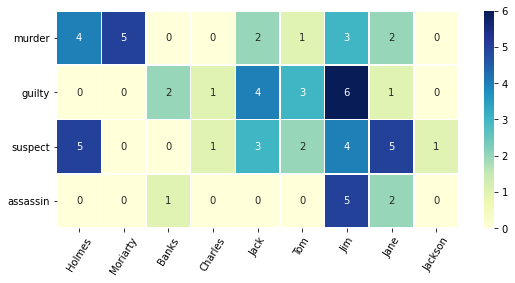

In [ ]:
def visualize_co_occurrence(data, keywords_rows, closeness_words_columns):

    #create a dataframe from the provided data
    df = pandas.DataFrame(data, index=keywords_rows, columns=closeness_words_columns)

    #set plot size according to the number of cols and rows
    plt.figure(figsize=(len(columns_example),len(rows_example)))

    #set color of heatmap
    heatmap = sns.heatmap(df, cmap="YlGnBu", annot=True, linewidths=.5)

    #rotate text
    loc_x, labels_x = plt.xticks()
    loc_y, labels_y = plt.yticks()
    heatmap.set_xticklabels(labels_x, rotation=58)
    heatmap.set_yticklabels(labels_y, rotation=0)
    

#example of expected format of data that the method needs
rows_example = ["murder", "guilty","suspect","assassin"]
columns_example = ["Holmes", "Moriarty","Banks","Charles","Jack","Tom","Jim","Jane","Jackson"]
data_example = [[4,5,0,0,2,1,3,2,0],[0,0,2,1,4,3,6,1,0],[5,0,0,1,3,2,4,5,1],[0,0,1,0,0,0,5,2,0]]

#call method
visualize_co_occurrence(data_example,rows_example,columns_example)


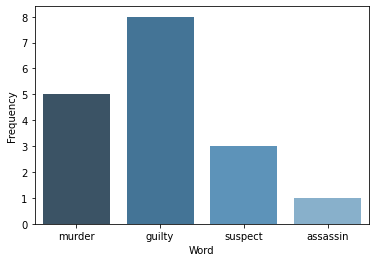

In [ ]:
def histogram_words(data, labels):
    #prepare the data to pandas
    data_ = [labels, data]
    data_ = np.asarray(data_).transpose()
    
    #create a dataframe from the provided data
    df = pandas.DataFrame(data_, columns=["Word", "Frequency"])
    sns.barplot(x="Word", y="Frequency", data=df, palette="Blues_d")

#example of expected format of data that the method needs
labels_example = ["murder", "guilty","suspect","assassin"]
data_example = [5,8,3,1]

histogram_words(data_example,labels_example)

###$\color{brown}{\rm Drivers}$

# Negative words frequency/histogram

In [95]:
def get_negative_words(url):
    with urllib.request.urlopen(url) as fd:
        text = fd.read()
        try:
            return text.decode('utf-8')
        except UnicodeDecodeError:
            return text.decode('iso-8859-1')

def count_negative_words(url, corpus, top):
    #read all words from the specified url
    negative_words_text = get_negative_words(url)
    negative_words_list = [negative_words_text[match.span()[0]:match.span()[1]-1] for match in re.finditer(r'(?<=[a-z]\n)[a-z]*\n', negative_words_text)]

    #count words from the corpus
    count_list = []
    for word in negative_words_list:
        list_found = [match.span() for match in re.finditer(fr'(?<![a-z]){word}(?![a-z])', corpus)]
        count_list.append(len(list_found))

    #sort the results and return just the indicated top
    new_list = np.asarray(list(zip(negative_words_list, count_list)), dtype = [('word', np.unicode_, 16), ('frequency', float)])
    data_sorted = np.sort(new_list, order='frequency', kind="quicksort")
    data_sorted = data_sorted[::-1]
    return data_sorted[:top]

#Get corpus
corpus = get_corpus('The Valley of Fear')
corpus_l = corpus.lower()

#get top results of negative word
url_ = "https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/08a269765a6b185d5f3dd522c876043ba9628715/data/opinion-lexicon-English/negative-words.txt"
results = count_negative_words(url_, corpus_l, top=20)
print(results)

[('fear', 47.) ('murder', 39.) ('crime', 36.) ('dead', 31.)
 ('danger', 30.) ('doubt', 27.) ('dark', 24.) ('strange', 22.)
 ('hard', 22.) ('bad', 19.) ('trouble', 17.) ('terrible', 15.)
 ('cold', 15.) ('struck', 14.) ('stranger', 14.) ('death', 14.)
 ('criminal', 14.) ('worse', 13.) ('dumb', 13.) ('warning', 12.)]


In [ ]:
corpus = get_corpus('The Valley of Fear')
corpus_l = corpus.lower()

# Get region of interest (ROI)
roi_spans = get_rois(corpus_l)  # all text
#roi_spans = get_rois(corpus_l, 'part')  # parts
roi_span = roi_spans[0]
print(roi_spans)
print(roi_span)

# Search keywords
keywords = ['dead', 'death', 'murder', 'crime', 'hurt', 'blood', 'treasure',
            'suffer', 'guilty', 'assassin', 'suspect', 'pain']
keyword_spans = get_keywords_map(corpus_l, roi_span, keywords)

[(672, 319494)]
(672, 319494)


In [ ]:
# Generate frequency table
keyword_freq = generate_frequency_map(keyword_spans, threshold=5)
print(keyword_freq)

defaultdict(<class 'int'>, {'dead': 37, 'death': 14, 'murder': 67, 'crime': 38, 'blood': 33, 'treasure': 7, 'guilty': 9, 'assassin': 9, 'pain': 6})


['dead', 'death', 'murder', 'crime', 'blood', 'treasure', 'guilty', 'assassin', 'pain']
[37, 14, 67, 38, 33, 7, 9, 9, 6]


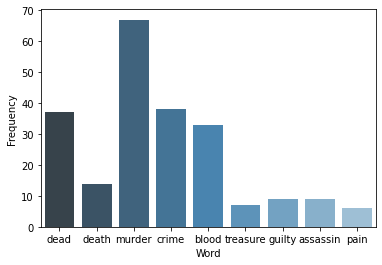

In [ ]:
# Plot
labels = list(keyword_freq.keys())
data = list(keyword_freq.values())
print(labels)
print(data)
histogram_words(data, labels)